In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

(1024, 768, 3)


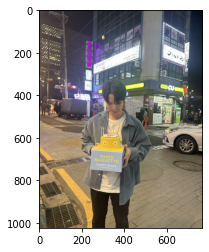

In [2]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/human.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [3]:
gray = cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

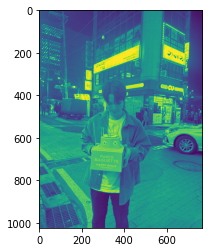

In [4]:
plt.imshow(gray)
plt.show()

In [5]:
kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

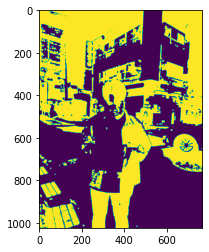

In [6]:
plt.imshow(opening)
plt.show()

In [7]:
def show_img(param):
    plt.imshow(param)
    plt.show()

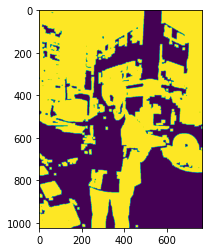

In [8]:
sure_bg = cv2.dilate(opening, kernel, iterations=3)
show_img(sure_bg)

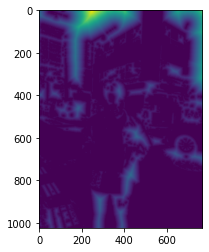

In [9]:
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
show_img(dist_transform)

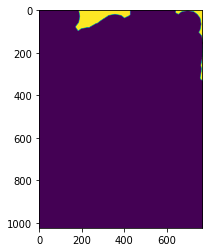

In [10]:
ret, sure_fg = cv2.threshold(dist_transform, 0.5*dist_transform.max(), 255,0)
sure_fg = np.uint(sure_fg)
show_img(sure_fg)

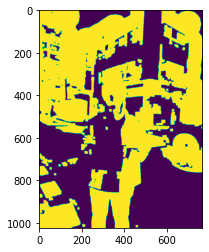

In [11]:
unknown = cv2.subtract(sure_bg.astype(np.int32), sure_fg.astype(np.int32)).astype(np.uint8)

show_img(unknown)

In [12]:
sure_fg = sure_fg.astype(np.uint8)
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

markers = cv2.watershed(img_orig, markers)
img_orig[markers == -1] = [255,0,0]

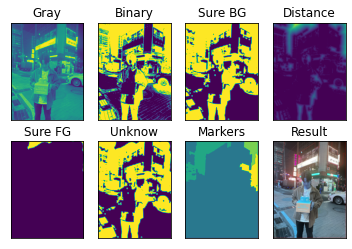

In [13]:
images = [gray,thresh,sure_bg,  dist_transform, sure_fg, unknown, markers, img_orig]
titles = ['Gray','Binary','Sure BG','Distance','Sure FG','Unknow','Markers','Result']

for i in range(len(images)):
    plt.subplot(2,4,i+1),plt.imshow(images[i]),plt.title(titles[i]),plt.xticks([]),plt.yticks([])

plt.show()

In [14]:
model_dir = os.getenv('HOME')+ '/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir,'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f18b67d9220>)

In [15]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [16]:
segvalues, output = model.segmentAsPascalvoc(img_path)

In [17]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

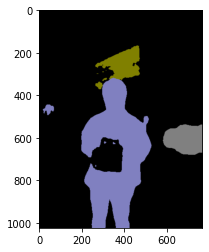

In [18]:
show_img(output)

In [19]:
segvalues

{'class_ids': array([ 0,  6,  7, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [20]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
bus
car
person


In [21]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [22]:
colormap[15]

array([192, 128, 128])

In [23]:
colormap[15]

array([192, 128, 128])

In [24]:
seg_color = (128,128,192)

(1024, 768)


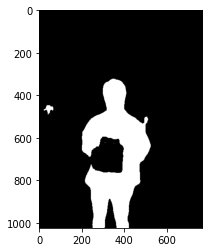

In [25]:
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

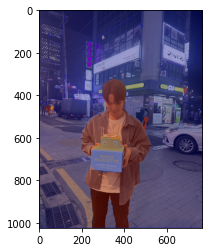

In [26]:
img_show = img_orig.copy()

img_mask = seg_map.astype(np.uint8)*255

color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

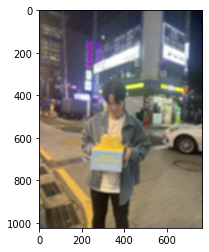

In [27]:
img_orig_blur = cv2.blur(img_orig, (13,13))

plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

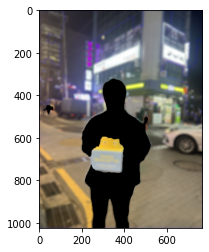

In [28]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)

img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

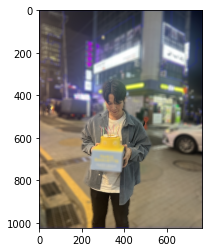

In [29]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

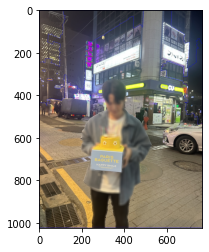

In [30]:
img_concat = np.where(img_mask_color==0, img_orig, img_orig_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()